# Simulate PWV effet on differential color light curves For Multiple Airmass

Generate SED

- author Sylvie Dagoret-Campagne
- creation date : 2024/09/10
- update : 2024/08/11

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd

from astropy.io import fits
from astropy import units as u
from astropy import constants as c

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import pickle

In [2]:
from scipy import interpolate
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree, BallTree

In [3]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Be sure to run this notebook in conda environment named conda_py310


## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

### libradtran Emulator

In [4]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.2


In [5]:
from getObsAtmo import ObsAtmo
OBS_tag = "AUXTEL"
emul = ObsAtmo(OBS_tag)
#emul = ObsAtmo("LSST")

AUXTEL site name validated as LSST observatory


In [6]:
WL = emul.GetWL()

#### Library to fit atmosphere

In [7]:
import sys
sys.path.append('../lib')
#import libAtmosphericFit

#### Library that encapsulate calculations for Photometric correction

In [8]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


In [9]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [10]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

#### library rubin_sim defining LSST parameters, namely for photometric calculations

In [11]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

In [12]:
# reference flux in Jy
F0 = ((0.*u.ABmag).to(u.Jy)).value
F0

3630.7805477010033

## Configuration

In [13]:
am0 =1.20    # airmass
pwv0 = 3.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [14]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)
pc1 = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)
pc2 = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)
pc3 = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

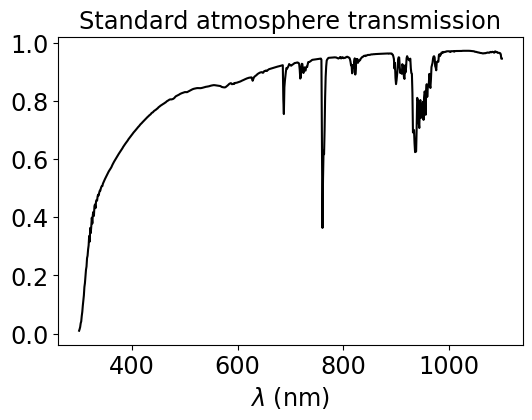

In [15]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

### Check LSST instrument throughput

Photometric Correction package should find the instrumental passband of LSST

Text(0.5, 1.0, 'Instrument throughput (auxtel)')

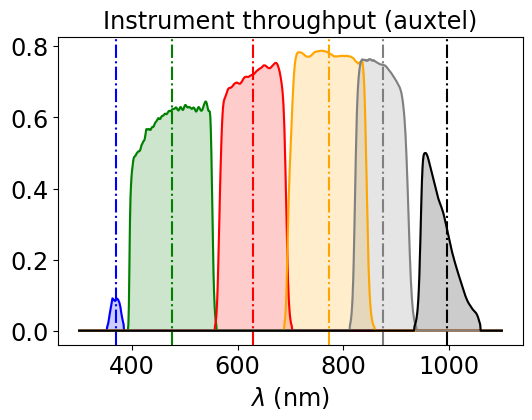

In [16]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput (auxtel)")

### Check LSST standard Filter throughputs

Text(0.5, 1.0, 'Total filter throughput (auxtel)')

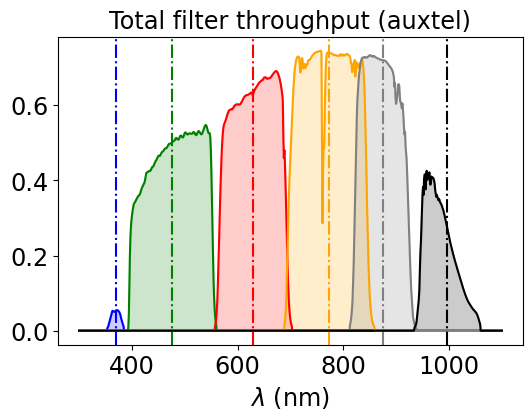

In [17]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total filter throughput (auxtel)")

## Variation of PWV

In [18]:
am = 1.2
oz = 300
tau= 0.04
beta = 1
all_pwv = np.arange(0,10,0.05)
NPWV = len(all_pwv)

In [19]:
pc.CalculateMultiObs(am,all_pwv,oz,tau,beta)

### PWV variation :  Observed filter and normalized response

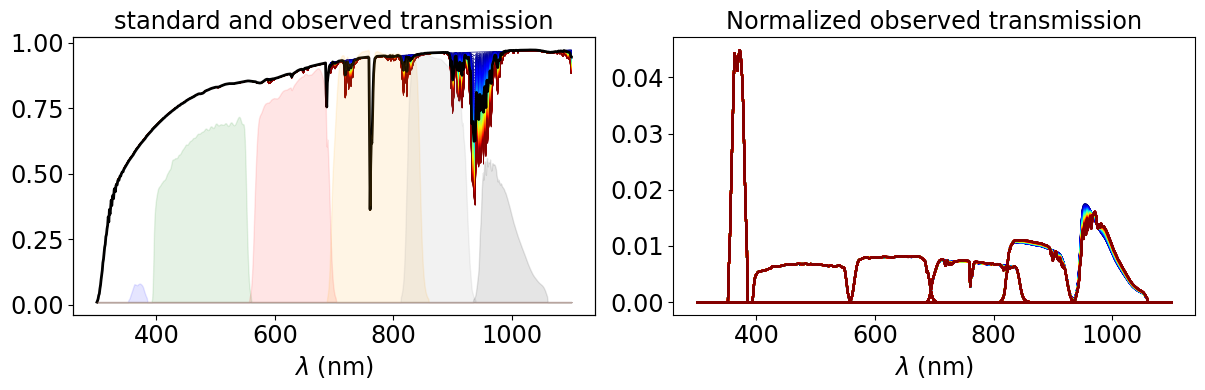

In [20]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,4))

# Figure 1
axs=fig.add_subplot(1,2,1)
for index,pwv in enumerate(all_pwv):
  
    atm = pc.coll_atm_nonstd[index]
    
    label = f"pwv={pwv:.1f}" 
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



# Figure 2
axs=fig.add_subplot(1,2,2)

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


for idx_pwv,pwv in enumerate(all_pwv):
    
    label = f"pwv={pwv:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_pwv][ifilt,:]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  


plt.tight_layout()
plt.show()



## Flat SED

In [21]:
# Find the throughputs directory 
#fdir = os.getenv('RUBIN_SIM_DATA_DIR')
fdir = get_data_dir()
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')

In [22]:
the_sed_flat = Sed()
the_sed_flat.set_flat_sed()
the_sed_flat.name = 'flat'

In [23]:
zmag = 20.0
flux_norm = the_sed_flat.calc_flux_norm(zmag, pc.bandpass_total_std['z'])
the_sed_flat.multiply_flux_norm(flux_norm)

### Check the calculation of the Magnitude and the ADC counts (observation)

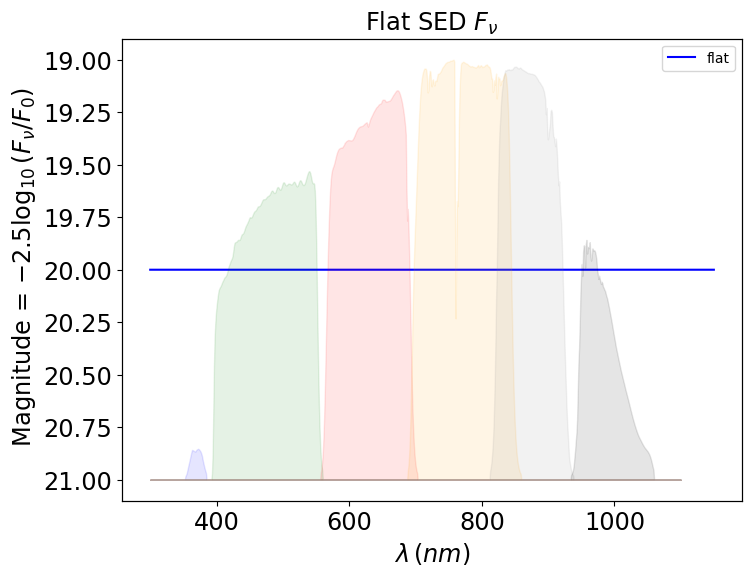

In [24]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(the_sed_flat .wavelen,-2.5*np.log10(the_sed_flat.fnu/F0),"b-",label=the_sed_flat.name)

ax.legend()
#ax.set_ylim(1e-17,1e-14)
#ax.set_xlim(300.,2000.)
ax.set_title("Flat SED $F_\\nu$")
ax.set_ylabel(" Magnitude = $-2.5 \log_{10}(F_\\nu/F_0)$")
ax.set_xlabel("$\\lambda \, (nm)$")
ax.yaxis.set_inverted(True)


ax3 = ax.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax3.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax3.set_yticks([])
    

## Generate a series of SED with different slopes in Fnu

In [25]:
photom_wl= FILTERWL[:,0]
lambda0z = photom_wl[4]

In [26]:
all_alphas = np.arange(-3.,3.1,0.2)
Nalphas = len(all_alphas)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=all_alphas.min(), vmax=all_alphas.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(all_alphas, alpha=1)


In [27]:
Nalphas

31

In [28]:
all_seds = []
zmag = 20.0
for idx,alpha in enumerate(all_alphas):
    label =f"sed{idx}_slope={alpha:.1f}"
    the_wl = the_sed_flat.wavelen
    the_fnu = np.power(the_wl/lambda0z,alpha)
    the_sed = Sed()
    the_sed.set_sed(the_wl, flambda=None, fnu=the_fnu,name=label)
   
    flux_norm = the_sed.calc_flux_norm(zmag, pc.bandpass_total_std['z'])
    the_sed.multiply_flux_norm(flux_norm)
    all_seds.append(the_sed)

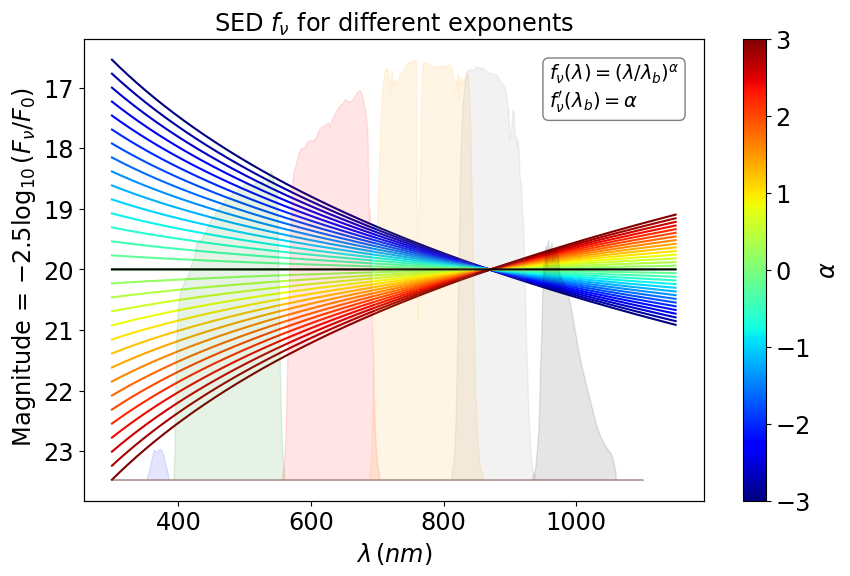

In [29]:
fig,ax = plt.subplots(1,1,figsize=(10,6))


for idx,the_sed in enumerate(all_seds):
    ax.plot(the_sed.wavelen,-2.5*np.log10(the_sed.fnu/F0),"-",c=all_colors[idx],label=the_sed.name)
ax.plot(the_sed_flat .wavelen,-2.5*np.log10(the_sed_flat.fnu/F0),"k-",label=the_sed_flat.name)


cbar =fig.colorbar(scalarMap,ax=ax, orientation='vertical', label='$\\alpha$')

#ax.legend()
#ax.set_ylim(1e-17,1e-14)
#ax.set_xlim(300.,2000.)
ax.set_title("SED $f_\\nu$ for different exponents")
ax.set_ylabel(" Magnitude = $-2.5 \log_{10}(F_\\nu/F_0)$")
ax.set_xlabel("$\\lambda \, (nm)$")
ax.yaxis.set_inverted(True)

textstr1 = "$f_\\nu(\\lambda) = (\\lambda/\\lambda_b)^\\alpha$"
textstr2 = "$f_\\nu^\prime(\lambda_b) = \\alpha$"
textstr = "\n".join((textstr1,textstr2))

ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax3 = ax.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax3.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax3.set_yticks([])

In [30]:
the_sed = all_seds[0]

mags_std = {}
for index,f in enumerate(filter_tagnames) :
    mags_std[f] = the_sed.calc_mag(pc.bandpass_total_std[f])
mags_std["g-r"] = mags_std["g"]- mags_std["r"]  
mags_std["z-y"] = mags_std["z"]- mags_std["y"]   
dfmag = pd.DataFrame(mags_std, index=[the_sed.name]).T
dfmag

,sed0_slope=-3.0
u,17.211071
g,17.985302
r,18.926322
i,19.584869
z,20.000000
y,20.398369
g-r,-0.941020
z-y,-0.398369


In [31]:
photoparams = set_photometric_parameters(30, 1 , readnoise=None)
adcs_stdmag = {}
for index,f in enumerate(filter_tagnames) :
    adcs_stdmag[f] = -2.5*np.log10(the_sed.calc_adu(pc.bandpass_total_std[f],photoparams))
adcs_stdmag["g-r"] = adcs_stdmag["g"]- adcs_stdmag["r"]  
adcs_stdmag["z-y"] = adcs_stdmag["z"]- adcs_stdmag["y"]      
dfadu = pd.DataFrame(adcs_stdmag, index=[the_sed.name]).T
dfadu

,sed0_slope=-3.0
u,-9.993510
g,-13.404943
r,-12.241072
i,-11.663871
z,-10.674300
y,-9.100017
g-r,-1.163871
z-y,-1.574283


## Simulate multi atmospheres

In [32]:
am = 1.2
am1 = 1.0
am2 = 1.5
am3 = 2.0
oz = 300
tau= 0.04
beta = 1
all_pwv = np.arange(0,15.,0.1)
NPWV = len(all_pwv)

In [33]:
pc.CalculateMultiObs(am,all_pwv,oz,tau,beta)
pc1.CalculateMultiObs(am1,all_pwv,oz,tau,beta)
pc2.CalculateMultiObs(am2,all_pwv,oz,tau,beta)
pc3.CalculateMultiObs(am3,all_pwv,oz,tau,beta)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


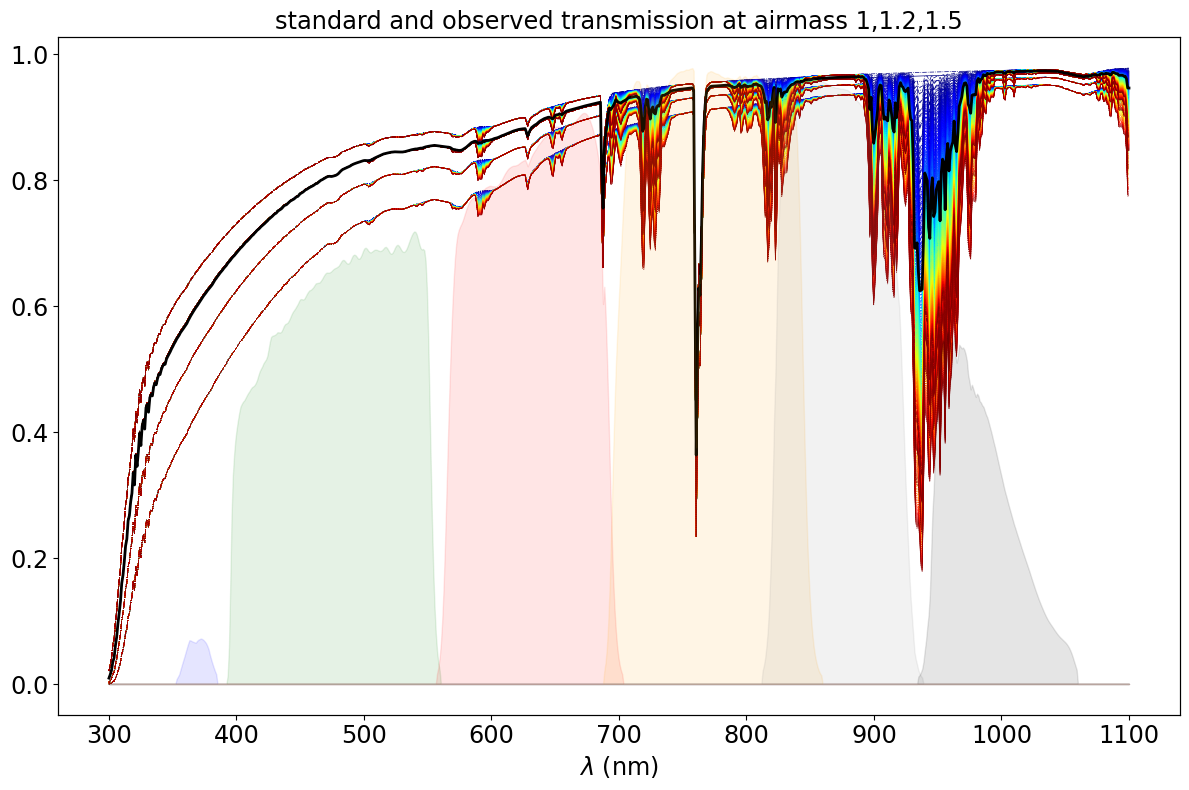

In [34]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,8))

# Figure 1
axs=fig.add_subplot(1,1,1)
for index,pwv in enumerate(all_pwv):

    #atm = pc.coll_bandpass_total_nonstd[index]
    atm = pc.coll_atm_nonstd[index]
    atm1 = pc1.coll_atm_nonstd[index]
    atm2 = pc2.coll_atm_nonstd[index]
    atm3 = pc3.coll_atm_nonstd[index]
    
    label = f"pwv={pwv:.1f}" 
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)
    axs.plot(pc1.WL,atm1,color=all_colors[index],ls="-.",lw=0.5)
    axs.plot(pc2.WL,atm2,color=all_colors[index],ls=":",lw=0.5)
    axs.plot(pc3.WL,atm3,color=all_colors[index],ls=":",lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission at airmass 1,1.2,1.5")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])


plt.tight_layout()
plt.show()


## Note the passbands for each of the PWV conditions are in pc.coll_bandpass_total_nonstd

In [35]:
len(pc.coll_bandpass_total_nonstd)

150

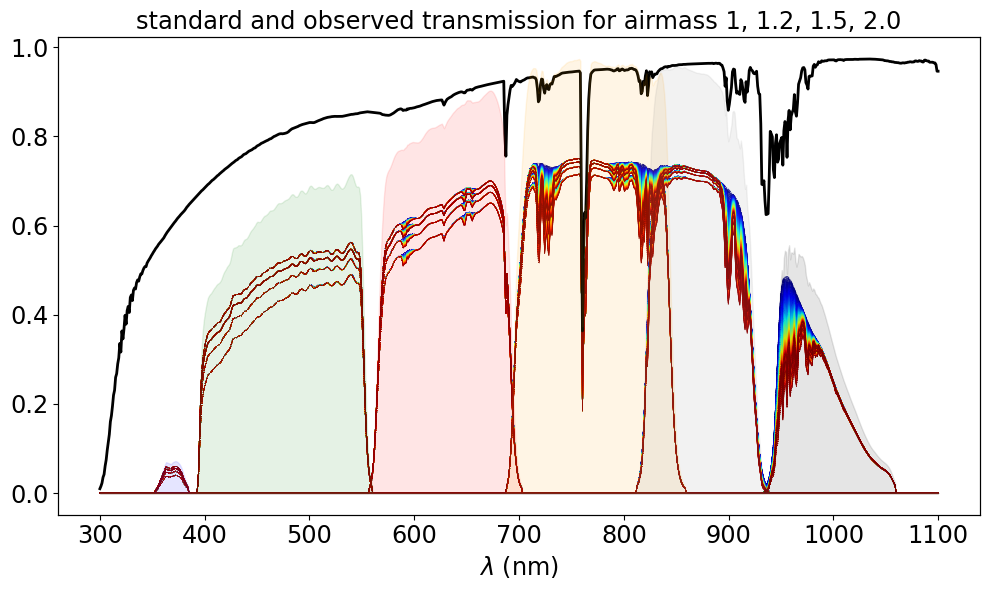

In [36]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(10,6))

# Figure 1
axs=fig.add_subplot(1,1,1)
for index,pwv in enumerate(all_pwv):
  
    atm_bands = pc.coll_bandpass_total_nonstd[index]
    atm_bands1 = pc1.coll_bandpass_total_nonstd[index]
    atm_bands2 = pc2.coll_bandpass_total_nonstd[index]
    atm_bands3 = pc3.coll_bandpass_total_nonstd[index]
    
    label = f"pwv={pwv:.1f}" 

    for f in filter_tagnames: 
        axs.plot(atm_bands[f].wavelen,atm_bands[f].sb,color=all_colors[index],label=label,lw=0.5)
        axs.plot(atm_bands1[f].wavelen,atm_bands1[f].sb,color=all_colors[index],ls="-.",lw=0.5)
        axs.plot(atm_bands2[f].wavelen,atm_bands2[f].sb,color=all_colors[index],ls=":",lw=0.5)
        axs.plot(atm_bands3[f].wavelen,atm_bands3[f].sb,color=all_colors[index],ls=":",lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission for airmass 1, 1.2, 1.5, 2.0")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])


plt.tight_layout()
plt.show()


## Compute the Magnitudes in all these transmission

- in all_df_magcol

In [37]:
def ComputeColors(the_pc,the_sed1,the_sed2):
    """
    Compute G-R and Z-R for both SED 1 and 2 independently for each at pwv conditions in the_pc
    Return the dataframe  in color for both sed independently
    """
    
    all_df_magcol = []
    for index,pwv in enumerate(all_pwv):
        atm_bands = the_pc.coll_bandpass_total_nonstd[index]
        mags_pwv1 = {}
        mags_pwv2 = {}
        madus_pwv1 = {}
        madus_pwv2 = {}
        for f in filter_tagnames: 
            mags_pwv1[f] = the_sed1.calc_mag(atm_bands[f])
            mags_pwv2[f] = the_sed2.calc_mag(atm_bands[f])
            madus_pwv1[f] = -2.5*np.log10(the_sed1.calc_adu(atm_bands[f],photoparams))
            madus_pwv2[f] = -2.5*np.log10(the_sed2.calc_adu(atm_bands[f],photoparams))
        # AB colors for star 1
        mags_pwv1["g-r"] = mags_pwv1["g"]- mags_pwv1["r"]  
        mags_pwv1["z-y"] = mags_pwv1["z"]- mags_pwv1["y"] 
        # AB colors for star 2
        mags_pwv2["g-r"] = mags_pwv2["g"]- mags_pwv2["r"]  
        mags_pwv2["z-y"] = mags_pwv2["z"]- mags_pwv2["y"] 
        # ADU mag colors for star 1
        # MADU colors for star 1
        madus_pwv1["g-r"] = madus_pwv1["g"]- madus_pwv1["r"]  
        madus_pwv1["z-y"] = madus_pwv1["z"]- madus_pwv1["y"] 
        # MADU colors for star 2
        madus_pwv2["g-r"] = madus_pwv2["g"]- madus_pwv2["r"]  
        madus_pwv2["z-y"] = madus_pwv2["z"]- madus_pwv2["y"] 
        
        df1 = pd.DataFrame(mags_pwv1, index=["abmag_1"]).T
        df2 = pd.DataFrame(mags_pwv2, index=["abmag_2"]).T
        df3 = pd.DataFrame(madus_pwv1, index=["instmag_1"]).T
        df4 = pd.DataFrame(madus_pwv2, index=["instmag_2"]).T
        df = pd.concat([df1,df2,df3,df4],axis=1)
        all_df_magcol.append(df)
        
    return all_df_magcol
   

In [38]:
def ComputeRelativeDiffColor(the_all_df_magcol):
    """
    Compute the relative color difference
    """

    df_diffcol = pd.DataFrame(columns=["pwv","Czy1_Czy2_abmag","Czy1_Czy2_instmag"])
    for index,pwv in enumerate(all_pwv):
        the_df = the_all_df_magcol[index]
        DCzyabmag = the_df.loc["z-y","abmag_1"] - the_df.loc["z-y","abmag_2"]
        DCzyadumag = the_df.loc["z-y","instmag_1"] - the_df.loc["z-y","instmag_2"]
        df_diffcol.loc[index] = [pwv,DCzyabmag,DCzyadumag]

    # Relative difference color is in mmag for plotting
    df_diffcol["Czy1_Czy2_abmag_rel"] =  (df_diffcol["Czy1_Czy2_abmag"] - df_diffcol.loc[0,"Czy1_Czy2_abmag"])*1000
    df_diffcol["Czy1_Czy2_instmag_rel"] =  (df_diffcol["Czy1_Czy2_instmag"] - df_diffcol.loc[0,"Czy1_Czy2_instmag"])*1000

    # differentiation  mmag per mm
    dx = np.diff(df_diffcol.pwv.values).mean()
    dy1 = np.diff(df_diffcol["Czy1_Czy2_abmag_rel"].values)
    dy2 = np.diff(df_diffcol["Czy1_Czy2_instmag_rel"].values)
    z_y0 = df_diffcol.loc[0,"Czy1_Czy2_abmag"]
    return df_diffcol

## Loop1 : Difference color curve wrt the Flat SED

In [39]:
all_zerocoldiff = []
all_colordiffcurves = []

all_zerocoldiff3 = []
all_colordiffcurves3 = []


for idx,the_sed in enumerate(all_seds):
    the_sed1 = the_sed
    the_sed2 = the_sed_flat
    all_df_magcol = ComputeColors(pc,the_sed1,the_sed2)
    df_diffcol = ComputeRelativeDiffColor(all_df_magcol)
    # the color difference for PWV = 0
    z_y0 = df_diffcol.loc[0,"Czy1_Czy2_abmag"]
    all_zerocoldiff.append(z_y0)
    all_colordiffcurves.append(df_diffcol) 
    
    all_df_magcol = ComputeColors(pc3,the_sed1,the_sed2)
    df_diffcol = ComputeRelativeDiffColor(all_df_magcol)
    # the color difference for PWV = 0
    z_y0 = df_diffcol.loc[0,"Czy1_Czy2_abmag"]
    all_zerocoldiff3.append(z_y0)
    all_colordiffcurves3.append(df_diffcol) 
    
    
all_zerocoldiff = np.array(all_zerocoldiff)   
all_zerocoldiff3 = np.array(all_zerocoldiff3)   

Text(0, 0.5, '$\\Delta_{12} (Z-Y)$ mag (pwv = 0 mm)')

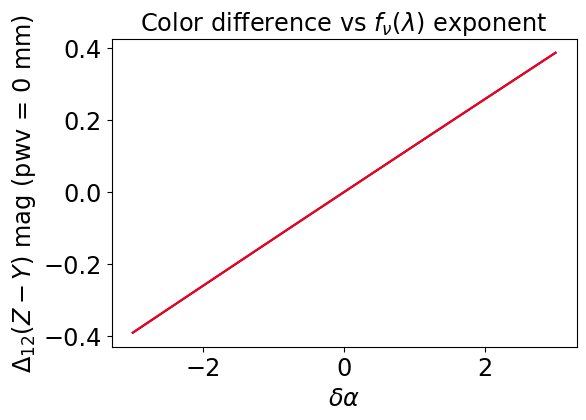

In [40]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(all_alphas,all_zerocoldiff,'b-')
ax.plot(all_alphas,all_zerocoldiff3,'r-')
ax.set_title("Color difference vs $f_\\nu(\\lambda)$ exponent ")
ax.set_xlabel("$\delta \\alpha $")
ax.set_ylabel("$\Delta_{12} (Z-Y)$ mag (pwv = 0 mm)")

In [41]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=all_zerocoldiff.min(), vmax=all_zerocoldiff.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)


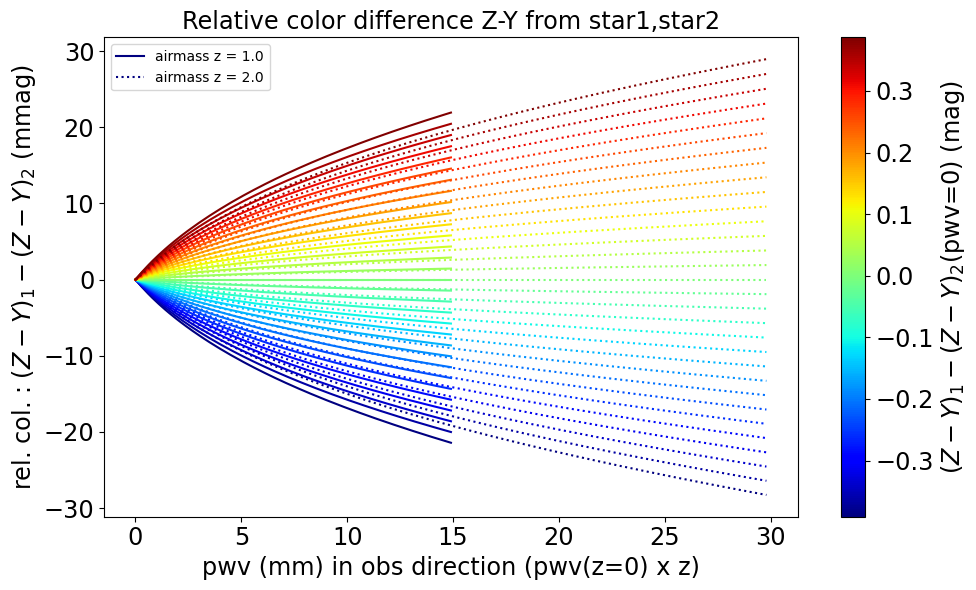

In [42]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

for idx,the_color_curve in enumerate(all_colordiffcurves):
    z_y0 = all_zerocoldiff[idx]
    z_y03 = all_zerocoldiff3[idx]
    the_color_curve3 = all_colordiffcurves3[idx]
    the_color = scalarMap.to_rgba(z_y0, alpha=1)
    the_color3 = scalarMap.to_rgba(z_y03, alpha=1)
    if idx==0:
        ax.plot(the_color_curve.pwv,the_color_curve.Czy1_Czy2_instmag_rel,c=the_color,label="airmass z = 1.0")
    else:
        ax.plot(the_color_curve.pwv,the_color_curve.Czy1_Czy2_instmag_rel,c=the_color)
        
    if idx==0:    
        ax.plot(the_color_curve3.pwv*2.0,the_color_curve3.Czy1_Czy2_instmag_rel,':',c=the_color3,label="airmass z = 2.0")
    else:
        ax.plot(the_color_curve3.pwv*2.0,the_color_curve3.Czy1_Czy2_instmag_rel,':',c=the_color3)
        

cbar = fig.colorbar(scalarMap,ax=ax, orientation='vertical', label='$(Z-Y)_1-(Z-Y)_2$(pwv=0) (mag)')    
ax.set_xlabel("pwv (mm) in obs direction (pwv(z=0) x z)")    
ax.set_ylabel("rel. col. : $(Z-Y)_1 - (Z-Y)_2$ (mmag)")
#ax.set_ylabel("Czy1_Czy2_abmag_rel (mmag)")
ax.set_title("Relative color difference Z-Y from star1,star2")
ax.legend(loc="upper left")

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
Nlabels = len(labels)



# If want to change the number of labels
#cbar.ax.locator_params(axis='y', nbins=2*Nlabels) 
#labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

#Nlabels = len(labels)
#newlabels = []
#for ilab in range(0,Nlabels-1):
#    the_label = float(labels[ilab])
#    print(the_label)
#    the_alpha = np.interp(the_label, all_zerocoldiff, all_alphas)
#    newlabels.append(f"coldiff = {the_label:.1f}\n exp = {the_alpha:.1f}")
#cbar.ax.set_yticklabels(newlabels,rotation=0);
plt.tight_layout()


## Loop2 : Difference color curve between slanted slopes

In [43]:
all_zerocoldiff = []
all_colordiffcurves = []
all_alphadiff = []
Nsed = len(all_seds)
for idx in range(Nsed):
    the_sed1 = all_seds[idx]
    the_sed2 = all_seds[Nsed-1-idx]
    alphadiff = all_alphas[idx] - all_alphas[Nsed-1-idx]
    all_df_magcol = ComputeColors(pc,the_sed1,the_sed2)
    df_diffcol = ComputeRelativeDiffColor(all_df_magcol)
    # the color difference for PWV = 0
    z_y0 = df_diffcol.loc[0,"Czy1_Czy2_abmag"]
    all_zerocoldiff.append(z_y0)
    all_colordiffcurves.append(df_diffcol) 
    all_alphadiff.append(alphadiff) 
all_zerocoldiff = np.array(all_zerocoldiff)    
all_alphadiff = np.array(all_alphadiff) 

Text(0, 0.5, '$\\Delta_{12} (Z-Y)$ mag (pwv = 0 mm)')

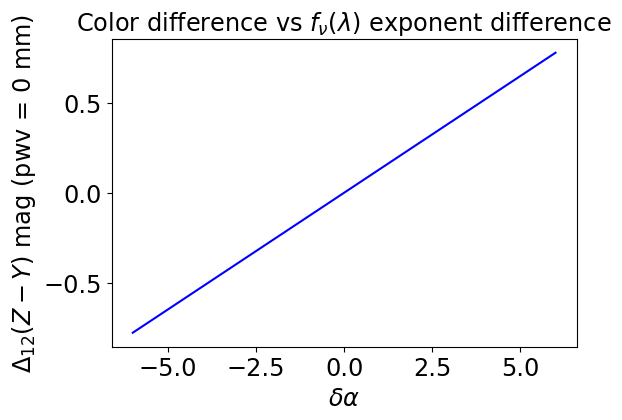

In [44]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(all_alphadiff,all_zerocoldiff,'b-')
ax.set_title("Color difference vs $f_\\nu(\\lambda)$ exponent difference ")
ax.set_xlabel("$\delta \\alpha $")
#ax.set_ylabel("Color diff (pwv = 0 mm)")
ax.set_ylabel("$\Delta_{12} (Z-Y)$ mag (pwv = 0 mm)")

In [45]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=all_zerocoldiff.min(), vmax=all_zerocoldiff.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

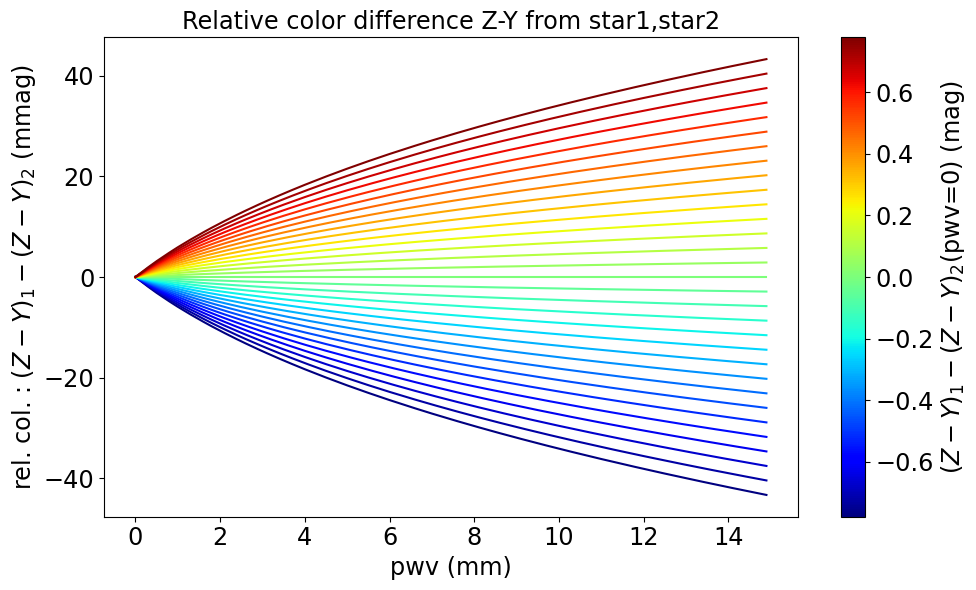

In [46]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

for idx,the_color_curve in enumerate(all_colordiffcurves):
    z_y0 = all_zerocoldiff[idx]
    the_color = scalarMap.to_rgba(z_y0, alpha=1)
    ax.plot(the_color_curve.pwv,the_color_curve.Czy1_Czy2_instmag_rel,c=the_color)

cbar = fig.colorbar(scalarMap,ax=ax, orientation='vertical', label='$(Z-Y)_1-(Z-Y)_2$(pwv=0) (mag)')    
ax.set_xlabel("pwv (mm)")    
#ax.set_ylabel("Czy1_Czy2_abmag_rel (mmag)")
ax.set_ylabel("rel. col. : $(Z-Y)_1 - (Z-Y)_2$ (mmag)")
ax.set_title("Relative color difference Z-Y from star1,star2")

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
Nlabels = len(labels)

# If want to change the number of labels
#cbar.ax.locator_params(axis='y', nbins=2*Nlabels) 
#labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

#Nlabels = len(labels)
#newlabels = []
#for ilab in range(0,Nlabels-1):
#    the_label = float(labels[ilab])
#    print(the_label)
#    the_alpha = np.interp(the_label, all_zerocoldiff, all_alphas)
#    newlabels.append(f"coldiff = {the_label:.1f}\n exp = {the_alpha:.1f}")
#cbar.ax.set_yticklabels(newlabels,rotation=0);
plt.tight_layout()

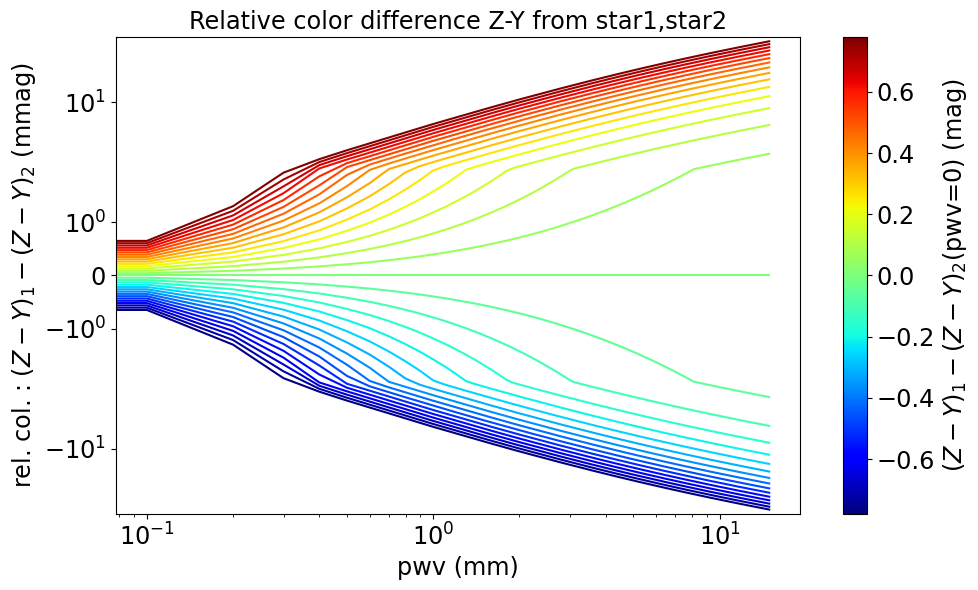

In [47]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

for idx,the_color_curve in enumerate(all_colordiffcurves):
    z_y0 = all_zerocoldiff[idx]
    the_color = scalarMap.to_rgba(z_y0, alpha=1)
    ax.plot(the_color_curve.pwv,the_color_curve.Czy1_Czy2_instmag_rel,c=the_color)

cbar = fig.colorbar(scalarMap,ax=ax, orientation='vertical', label='$(Z-Y)_1-(Z-Y)_2$(pwv=0) (mag)')    
ax.set_xlabel("pwv (mm)")    
#ax.set_ylabel("Czy1_Czy2_abmag_rel (mmag)")
ax.set_ylabel("rel. col. : $(Z-Y)_1 - (Z-Y)_2$ (mmag)")
ax.set_title("Relative color difference Z-Y from star1,star2")
ax.set_xscale('log')
ax.set_yscale('symlog')
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
Nlabels = len(labels)

# If want to change the number of labels
#cbar.ax.locator_params(axis='y', nbins=2*Nlabels) 
#labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

#Nlabels = len(labels)
#newlabels = []
#for ilab in range(0,Nlabels-1):
#    the_label = float(labels[ilab])
#    print(the_label)
#    the_alpha = np.interp(the_label, all_zerocoldiff, all_alphas)
#    newlabels.append(f"coldiff = {the_label:.1f}\n exp = {the_alpha:.1f}")
#cbar.ax.set_yticklabels(newlabels,rotation=0);
plt.tight_layout()

## Interpolator

In [48]:
from scipy.interpolate import RegularGridInterpolator

In [49]:
nx = len(all_pwv)
ny = len(all_zerocoldiff)
datagrid = np.zeros((ny,nx))
xg, yg = np.meshgrid(all_pwv, all_zerocoldiff , indexing='ij')

In [50]:
for idx,the_color_curve in enumerate(all_colordiffcurves):
    z_y0 = all_zerocoldiff[idx]
    datagrid[idx,:] = the_color_curve.Czy1_Czy2_instmag_rel

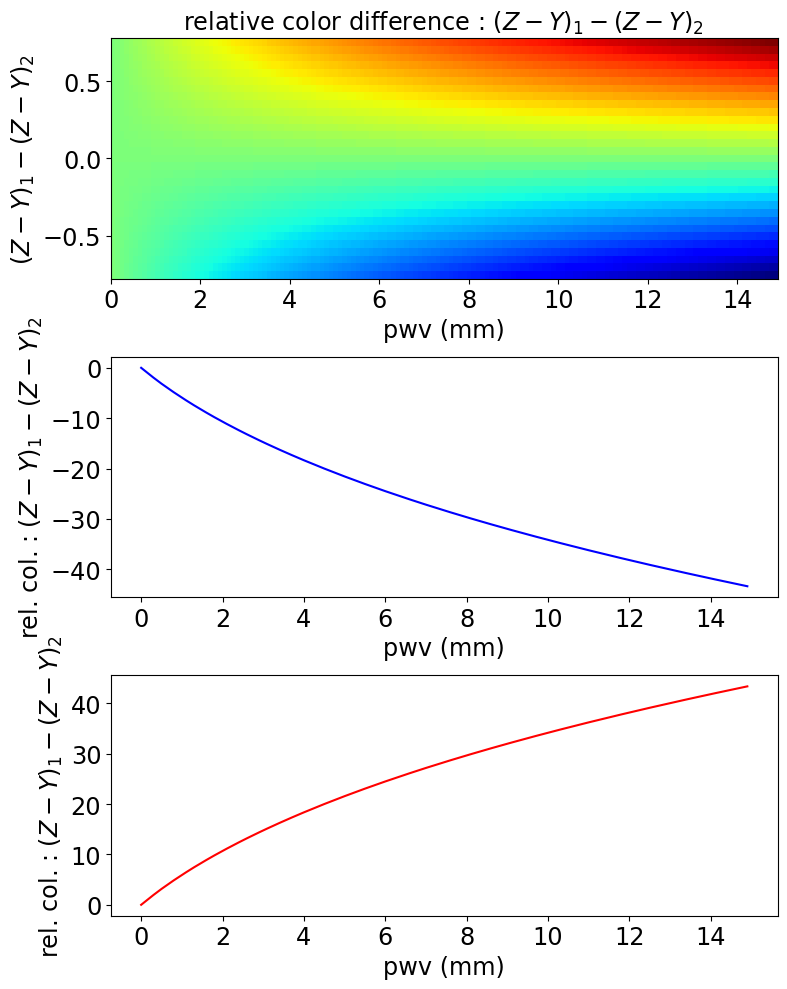

In [51]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(8,10))
im = ax1.imshow(datagrid,origin="lower",cmap="jet",
           extent=(all_pwv.min(),all_pwv.max(),all_zerocoldiff.min(),all_zerocoldiff.max()),aspect='auto')
#cbar

ax1.set_title("relative color difference : $(Z-Y)_1 - (Z-Y)_2$ ")
ax1.set_ylabel("$(Z-Y)_1-(Z-Y)_2$")
ax1.set_xlabel("pwv (mm)")
#ax1.set_aspect('auto')

ax2.plot(all_pwv, datagrid[0,:],'b-')
ax2.set_xlabel("pwv (mm)")
ax2.set_ylabel("rel. col. : $(Z-Y)_1 - (Z-Y)_2$")
ax3.plot(all_pwv, datagrid[-1,:],'r-')
ax3.set_xlabel("pwv (mm)")
ax3.set_ylabel("rel. col. : $(Z-Y)_1 - (Z-Y)_2$")

plt.tight_layout()
plt.show()

In [52]:
interp = RegularGridInterpolator((all_pwv, all_zerocoldiff), datagrid.T, bounds_error=False, fill_value=None)

Text(0.5, 1.0, 'Relative color difference Z-Y from star1,star2')

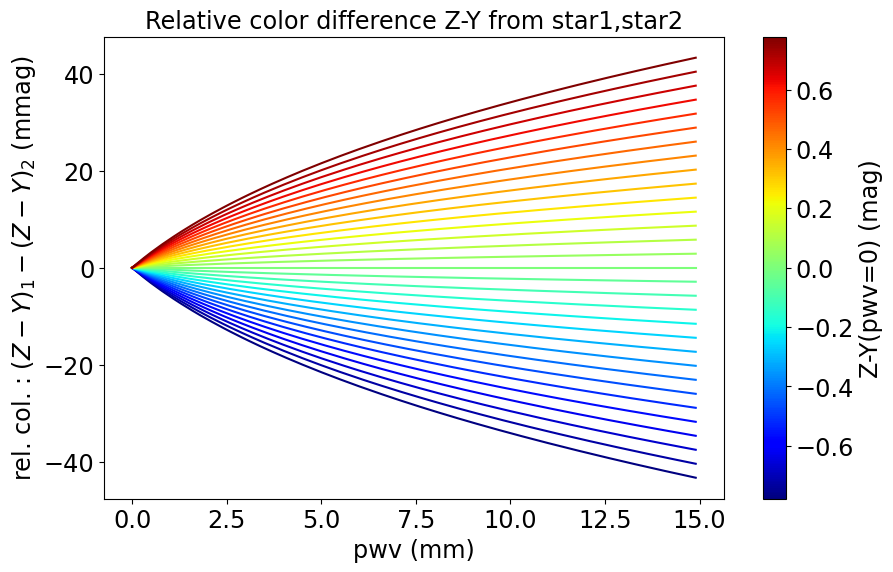

In [53]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

for z_y0 in all_zerocoldiff:
    the_color = scalarMap.to_rgba(z_y0, alpha=1)
    
    pts = list(zip(all_pwv,z_y0*np.ones(len(all_pwv))))  
    c = interp(pts)
    ax.plot(all_pwv,c,'-',c=the_color)
    
cbar = fig.colorbar(scalarMap,ax=ax, orientation='vertical', label='Z-Y(pwv=0) (mag)')    
ax.set_xlabel("pwv (mm)")    
#ax.set_ylabel("Czy1_Czy2_abmag_rel (mmag)")
ax.set_ylabel("rel. col. : $(Z-Y)_1 - (Z-Y)_2$ (mmag)")
ax.set_title("Relative color difference Z-Y from star1,star2")

## Save files

In [54]:
file0_out = f"{OBS_tag}_atmosphericzycolorgrid_params.pickle"
file1_out = f"{OBS_tag}_atmosphericzycolorgrid_datagrid.npy"

In [55]:
info_params = {}
info_params["OBS"] = OBS_tag

In [56]:
#########################
# ### PWV
#########################

PWVMIN = all_pwv.min()
PWVMAX = all_pwv.max()
DPWV = np.median(np.diff(all_pwv))
pwvs = all_pwv
NPWV = len(pwvs)

info_params["PWVMIN"] = PWVMIN
info_params["PWVMAX"] = PWVMAX
info_params["NPWV"] = NPWV 
info_params["DPWV"] = DPWV 
info_params["PWV"]  = pwvs

msg = f"pwv - grid : Npoints = {NPWV}, valmin={PWVMIN:.3f} , valmax={PWVMAX:.3f} , valstep= {DPWV:.3f}"
print(msg)
print(pwvs)

########################
# ### Color difference

ZYDIFFCOLMIN = all_zerocoldiff.min()
ZYDIFFCOLMAX = all_zerocoldiff.max()
zycolldiff =  all_zerocoldiff
NZYDC = len(zycolldiff)

info_params["ZYDIFFCOLMIN"] = ZYDIFFCOLMIN
info_params["ZYDIFFCOLMAX"] = ZYDIFFCOLMAX
info_params["NZYDC"] = NZYDC
info_params["ZYCOLDIFF"]  = zycolldiff

msg = f"Z-Y - grid : Npoints = {NZYDC}, valmin={ZYDIFFCOLMIN:.3f} , valmax={ZYDIFFCOLMAX:.3f}"
print(msg)
print(zycolldiff)

with open(file0_out, 'wb') as handle:
    pickle.dump(info_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

pwv - grid : Npoints = 150, valmin=0.000 , valmax=14.900 , valstep= 0.100
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9]
Z-Y - grid : Npoints = 31, valmin=-0.778 , valmax=0.778
[-0.7780263  -0.72614567 -0.67426757 -0.6223918  -0.57051821 -0.51864659
 -0.46677679 -0.41490861 -0.3630418

In [57]:
np.save(file1_out,datagrid, allow_pickle=False)
print(f"...... datagrid file {file1_out} written")

...... datagrid file AUXTEL_atmosphericzycolorgrid_datagrid.npy written
